In [1]:
import pandas as pd
import numpy as np

The dataset is called "asap-sas". Official description at [Kaggle asap-sas](https://www.kaggle.com/c/asap-sas)

In [2]:
complete_dataset=pd.read_csv("C:/Users/superuser/Desktop/ResearchProject/sas-dataset.csv",encoding="ISO-8859-1")

In [3]:
complete_dataset.sample(5)

,Id,answer_set,score1,score2,question_key,student_response,answer_key
4474,14966,6,0,0,List and describe three processes used by cell...,One movement in the cell is the RNA. Another t...,Selective permeability is used by the cell mem...
4527,15019,6,0,0,List and describe three processes used by cell...,1. tRNA2. lysosomes3. other organelles,Selective permeability is used by the cell mem...
874,875,1,1,0,A group of students wrote the following proced...,In order to replicate the experiment one would...,how much vinegar was used in each container\nw...
1640,1641,1,2,2,A group of students wrote the following proced...,First you would name the four distrant substan...,how much vinegar was used in each container\nw...
5239,15731,6,0,0,List and describe three processes used by cell...,mRNAtRNArRNA,Selective permeability is used by the cell mem...


In [4]:
#finding average of score1 and score2
complete_dataset['avg_score']=complete_dataset[['score1','score2']].mean(axis=1).astype('int64')

In [5]:
complete_dataset.dtypes

Id                   int64
answer_set           int64
score1               int64
score2               int64
question_key        object
student_response    object
answer_key          object
avg_score            int64
dtype: object

In [6]:
complete_dataset.shape # there are around 5200 examples

(5264, 8)

In [7]:
complete_dataset.groupby('answer_set').count() # this dataset contains three answer-set with student response and reference answers

,Id,score1,score2,question_key,student_response,answer_key,avg_score
answer_set,,,,,,,
1,1672,1672,1672,1672,1672,1672,1672
5,1795,1795,1795,1795,1795,1795,1795
6,1797,1797,1797,1797,1797,1797,1797


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train, test=train_test_split(complete_dataset,test_size=0.4,random_state=42,shuffle=True)

In [10]:
multiIndex_dataset=pd.concat([train,test], keys=['train', 'test'])# MultiIndexing Pandas

In [11]:
texts=np.array(multiIndex_dataset["answer_key"]+" "+multiIndex_dataset["student_response"])

#### Count Vectorizer or TF-IDF(Term Frequency and Inverse Document Frequency)

Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

If you are working with basic NLP techniques like BOW, Count Vectorizer or TF-IDF(Term Frequency and Inverse Document Frequency) then removing stopwords is a good idea because stopwords act like noise for these methods.

# [Check here for detailed tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

In [13]:
vectorizer1 = CountVectorizer(stop_words='english')
text_frequency = vectorizer1.fit_transform(texts)
text_frequency.shape

(5264, 6163)

CountVectorizer supports counts of N-grams of words or consecutive characters. Once fitted, the vectorizer has built a dictionary of feature indices. The index value of a word in the vocabulary is linked to its frequency in the whole training corpus.

In [14]:
#Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency.
tfidf_transformer = TfidfTransformer().fit(text_frequency)
txt_tfidf=tfidf_transformer.transform(text_frequency)

In [15]:
train_tfidf=txt_tfidf[multiIndex_dataset.index.codes[0]==0,:]
train_tfidf_Y=train["avg_score"]
test_tfidf=txt_tfidf[multiIndex_dataset.index.codes[0]==1,:]
test_tfidf_Y=test["avg_score"]

In [16]:
tfidf_transformer = TfidfTransformer().fit(text_frequency)
txt_tfidf=tfidf_transformer.transform(text_frequency)

Now that we have the features, we can train a classifier to try to predict the score of student response. Let’s start with a naïve Bayes classifier, which provides a nice baseline for this task.

scikit-learn includes several variants of this classifier; the one most suitable for word counts is the multinomial variant:

In [17]:
from sklearn.naive_bayes import MultinomialNB

In [18]:
clf = MultinomialNB()
predictor_MultinomialNB= clf.fit(train_tfidf.toarray(), train_tfidf_Y)
y_pred_MultinomialNB= predictor_MultinomialNB.predict(train_tfidf.toarray())


In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

Cohen's kappa coefficient (κ) is a statistic that is used to measure inter-rater reliability (and also Intra-rater reliability) for qualitative (categorical) items. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance.<br>
The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall).

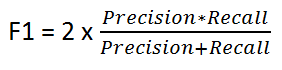


In [20]:
print (f1_score(train_tfidf_Y, y_pred_MultinomialNB, average='weighted',labels=np.unique(y_pred_MultinomialNB)))

0.657725677676107


In [21]:
y_test_MultinomialNB = predictor_MultinomialNB.predict(test_tfidf.toarray())
print (f1_score(test_tfidf_Y, y_test_MultinomialNB, average='weighted',labels=np.unique(y_test_MultinomialNB)))

0.6410607164738138


In [22]:
print("Multinomial naive Bayes")
print("Train mean-squared error ",np.mean(train_tfidf_Y == y_pred_MultinomialNB))
print("Test mean-squared error ",np.mean(test_tfidf_Y == y_test_MultinomialNB))
print("Train kappa score ",cohen_kappa_score(train_tfidf_Y, y_pred_MultinomialNB))
print("Test kappa score ",cohen_kappa_score(test_tfidf_Y, y_test_MultinomialNB))


Multinomial naive Bayes
Train mean-squared error  0.6732108929702343
Test mean-squared error  0.6505223171889839
Train kappa score  0.3708231842749813
Test kappa score  0.35008285309843745


In [23]:
from sklearn.linear_model import SGDClassifier

In [24]:
clf=SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=10000, tol=0.19)

In [25]:
predictor_SGD= clf.fit(train_tfidf.toarray(), train_tfidf_Y)
y_pred_SGD= predictor_SGD.predict(train_tfidf.toarray())

In [26]:
y_test_SGD = predictor_SGD.predict(test_tfidf.toarray())
print (f1_score(test_tfidf_Y, y_test_SGD, average='weighted',labels=np.unique(y_test_SGD)))

0.6548572224619804


In [27]:
print("Stochastic gradient descent")
print("Train mean-squared error ",np.mean(train_tfidf_Y == y_pred_SGD))
print("Test mean-squared error ",np.mean(test_tfidf_Y == y_test_SGD))
print("Train kappa score ",cohen_kappa_score(train_tfidf_Y, y_pred_SGD))
print("Test kappa score ",cohen_kappa_score(test_tfidf_Y, y_test_SGD))


Stochastic gradient descent
Train mean-squared error  0.7853071564281191
Test mean-squared error  0.7127255460588794
Train kappa score  0.5360431955389919
Test kappa score  0.38890969879775206


Achieved 70% accuracy using SVM